# Implementation that works with hugginface models and datasets for greater reproducibility

In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from datasets import load_dataset
from torch import nn
from torch.nn import functional as F
from tqdm.autonotebook import tqdm
from transformers import AutoImageProcessor, ResNetForImageClassification
from PIL import Image
import matplotlib.pyplot as plt

from src.adversarial_noise.utils import get_device
from src.adversarial_noise.fgsm import (
    iterative_fast_gradient_sign_target,
    tensor_to_image,
)
from src.adversarial_noise.evaluation import plot_adversarial_results


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
device = get_device()

Start using the same model and dataset as the existing example (resnet34 and tiny imagenet)

In [19]:
dataset = load_dataset("zh-plus/tiny-imagenet", trust_remote_code=False)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-34")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-34")


Define a test image

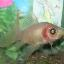

In [20]:
image = dataset["train"]["image"][0]
image


In [21]:
inputs = image_processor(image, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

goldfish, Carassius auratus


In [22]:
label_names = list(model.config.id2label.values())
label_names

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [23]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="eft",
    label_names=label_names,
    # epsilon=0.02,
    alpha=0.002,
    num_iter=10,
)

tensor([27], device='mps:0')
eft


In [24]:
with torch.no_grad():
    logits = model(adv_imgs.to(device)).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top 10 predictions
    top_probs, top_indices = torch.topk(probabilities, k=10)

    print("Top 10 predictions:")
    print("-" * 50)
    for prob, idx in zip(top_probs, top_indices):
        label = model.config.id2label[idx.item()]
        print(f"{label:<30} {prob.item() * 100:>6.2f}%")

Top 10 predictions:
--------------------------------------------------
eft                             98.72%
common newt, Triturus vulgaris   0.61%
goldfish, Carassius auratus      0.14%
axolotl, mud puppy, Ambystoma mexicanum   0.06%
spotted salamander, Ambystoma maculatum   0.05%
mongoose                         0.02%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui   0.01%
ringlet, ringlet butterfly       0.01%
European fire salamander, Salamandra salamandra   0.01%
Windsor tie                      0.01%


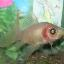

In [25]:
image

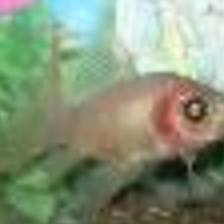

In [26]:
tensor_to_image(adv_imgs)

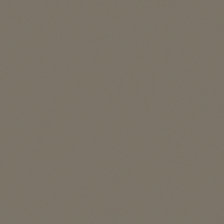

In [27]:
tensor_to_image(noise_grad)

In [28]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="ostrich, Struthio camelus",
    label_names=label_names,
    alpha=0.002,
    num_iter=10,
)

tensor([9], device='mps:0')
ostrich, Struthio camelus


In [29]:
with torch.no_grad():
    logits = model(adv_imgs.to(device)).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top 10 predictions
    top_probs, top_indices = torch.topk(probabilities, k=10)

    print("Top 10 predictions:")
    print("-" * 50)
    for prob, idx in zip(top_probs, top_indices):
        label = model.config.id2label[idx.item()]
        print(f"{label:<30} {prob.item() * 100:>6.2f}%")

Top 10 predictions:
--------------------------------------------------
ostrich, Struthio camelus       95.32%
patas, hussar monkey, Erythrocebus patas   0.78%
macaque                          0.68%
crane                            0.51%
baboon                           0.31%
hen                              0.24%
black stork, Ciconia nigra       0.17%
vulture                          0.09%
marmoset                         0.09%
hornbill                         0.08%


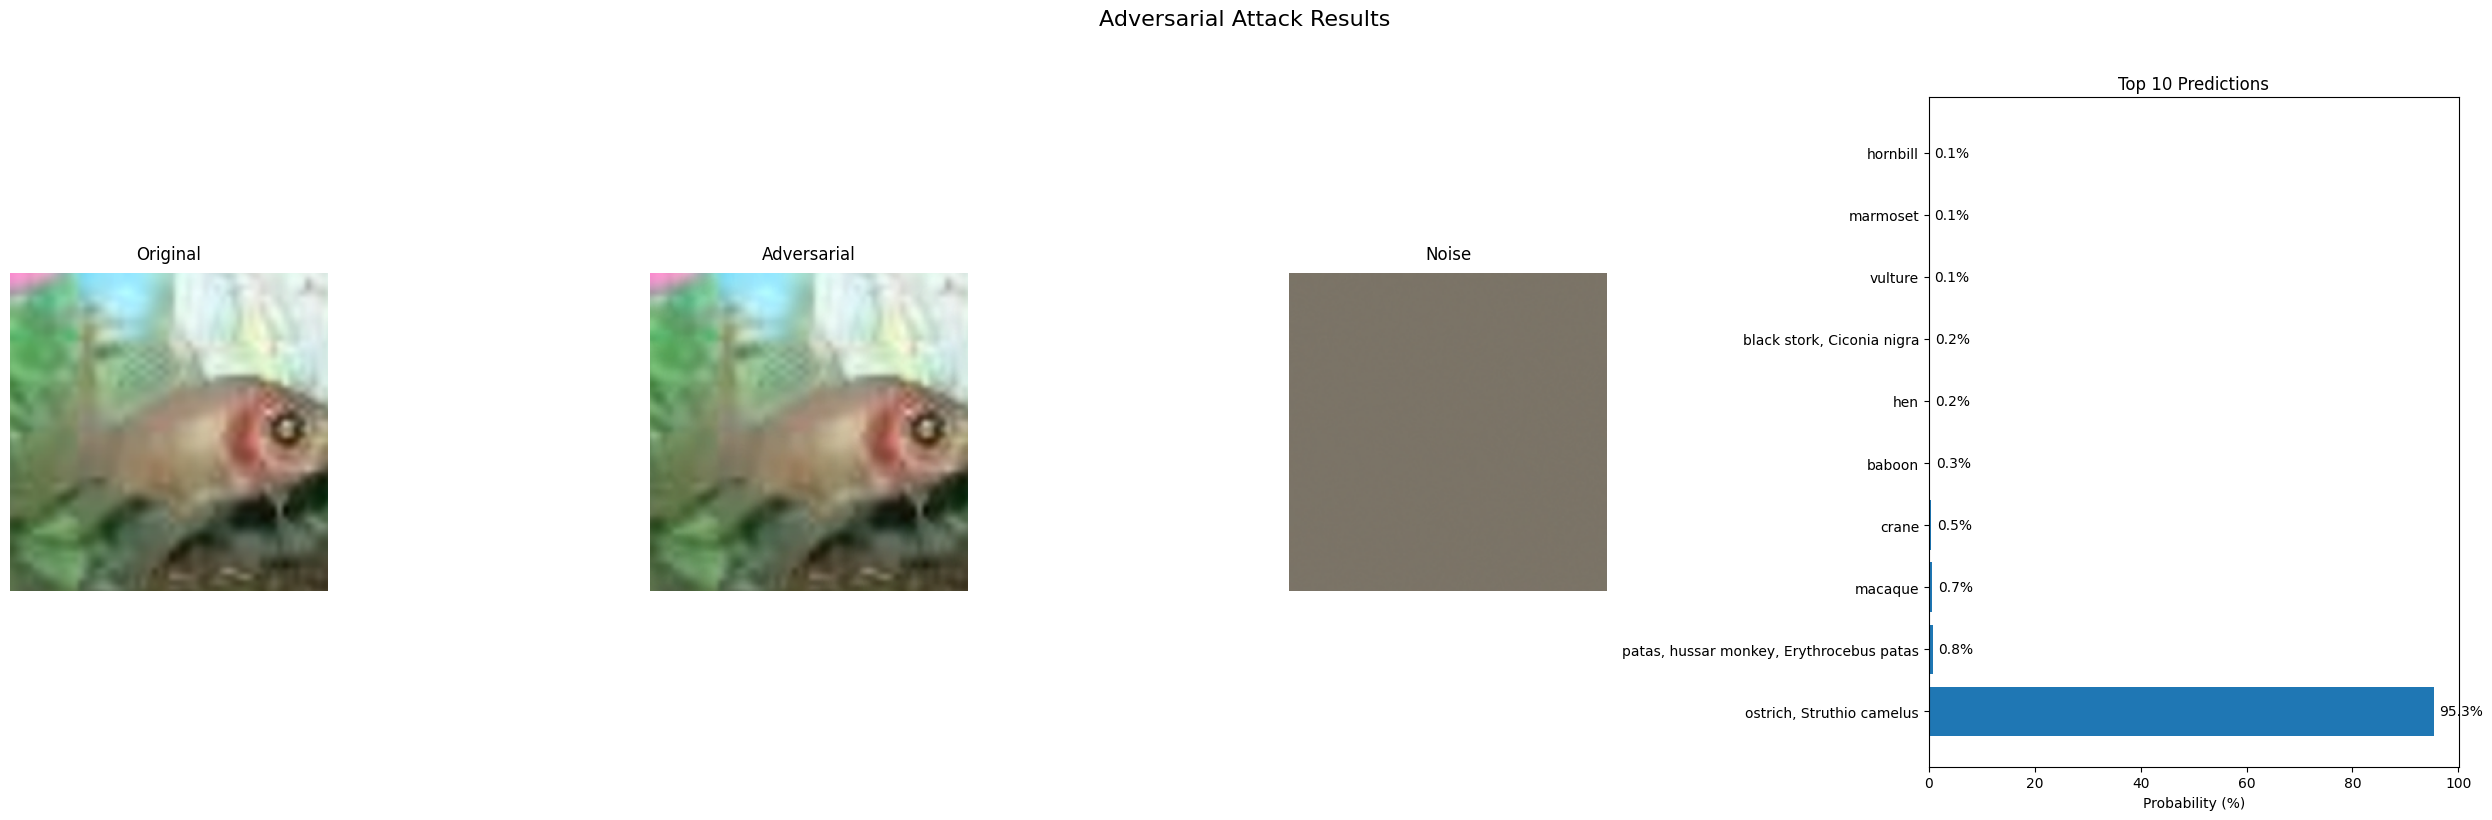

In [30]:
plot_adversarial_results(
    original_img=exmp_batch,
    adv_img=adv_imgs,
    noise_grad=noise_grad,
    model=model,
    device=device,
)

## Test with a different dataset 

In [31]:
dataset = load_dataset("huggingface/cats-image", trust_remote_code=False)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [32]:
image = dataset["test"]["image"][0]
inputs = image_processor(image, return_tensors="pt")

In [42]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    image=exmp_batch,
    target_label="ostrich, Struthio camelus",
    label_names=label_names,
    # epsilon=0.02,
    alpha=0.02,
    num_iter=10,
)

In [44]:
plot_adversarial_results(
    original_img=exmp_batch,
    adv_img=adv_imgs,
    noise_grad=noise_grad,
    model=model,
    device=device,
)

Still works, but requires higher alpha

# More thorough testing

In [49]:
dataset = load_dataset("zh-plus/tiny-imagenet", trust_remote_code=False)
seed = np.random.seed(42)  # Set a seed for reproducibility

In [51]:
def evaluate_adversarial_attacks(
    model: nn.Module,
    dataset: dict,
    image_processor: AutoImageProcessor,
    n_samples: int = 100,
    alpha: float = 0.002,
    num_iter: int = 10,
    device: str = "cuda",
    seed: int = 42,
) -> dict:
    """
    Evaluate adversarial attacks on multiple images with random targets.

    Args:
        model: The model to attack
        dataset: The dataset containing images
        image_processor: Processor to prepare images for the model
        n_samples: Number of attacks to attempt
        alpha: Step size for FGSM
        num_iter: Number of iterations for the attack
        device: Device to run the computations on

    Returns:
        dict: Results containing success rate and detailed statistics
    """
    # Get label names
    label_names = list(model.config.id2label.values())

    # Track results
    results = {
        "successful": 0,
        "failed": 0,
        "original_predictions": [],
        "target_labels": [],
        "final_predictions": [],
        "confidence_scores": [],
    }

    # Random indices for images

    random_indices = np.random.choice(len(dataset["train"]), n_samples)

    # Progress bar
    pbar = tqdm(random_indices, desc="Running adversarial attacks")

    for idx in pbar:
        # Get image and ensure it's in RGB format
        image = dataset["train"]["image"][idx]
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        if image.mode != "RGB":
            image = image.convert("RGB")

        # Process image
        inputs = image_processor(image, return_tensors="pt")
        image_tensor = inputs["pixel_values"].to(device)

        # Get original prediction
        with torch.no_grad():
            logits = model(image_tensor).logits
            original_pred = label_names[logits.argmax(-1).item()]

        # Select random target different from original prediction
        possible_targets = [l for l in label_names if l != original_pred]
        target_label = np.random.choice(possible_targets)

        # Attempt adversarial attack
        try:
            adv_imgs, _ = iterative_fast_gradient_sign_target(
                model=model,
                image=image_tensor,
                target_label=target_label,
                label_names=label_names,
                alpha=alpha,
                num_iter=num_iter,
            )

            # Check final prediction
            with torch.no_grad():
                logits = model(adv_imgs.to(device)).logits
                probs = F.softmax(logits, dim=-1)[0]
                final_pred = label_names[logits.argmax(-1).item()]
                confidence = probs.max().item()

            # Track results
            if final_pred == target_label:
                results["successful"] += 1
            else:
                results["failed"] += 1

            results["original_predictions"].append(original_pred)
            results["target_labels"].append(target_label)
            results["final_predictions"].append(final_pred)
            results["confidence_scores"].append(confidence)

        except Exception as e:
            print(f"Error on image {idx}: {str(e)}")
            results["failed"] += 1

    # Calculate success rate
    success_rate = (results["successful"] / n_samples) * 100
    print(f"\nSuccess rate: {success_rate:.2f}%")
    print(f"Failed attacks: {results['failed']}")

    return results


# Example usage:
model = model.to(device)
results = evaluate_adversarial_attacks(
    model=model,
    dataset=dataset,
    image_processor=image_processor,
    n_samples=10,
    alpha=0.02,
    num_iter=10,
    device=device,
    seed=seed,
)

Running adversarial attacks:   0%|          | 0/10 [00:00<?, ?it/s]


Success rate: 100.00%
Failed attacks: 0
